## Spark Initialization

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME
import findspark
findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Simple Data Clustering") \
    .getOrCreate()

In [3]:
# Print Spark object ID
print(spark)

## Loading Dataset

In [4]:
df = spark.read.csv("F:/Semester 6/BigData/DataSet/1-6m-accidents-traffic-flow-over-16-years/accidents_2012_to_2014.csv", header=True, inferSchema=True)

In [5]:
df.count()

464697

In [6]:
df.head()

Row(Accident_Index='201201BS70001', Location_Easting_OSGR=527200, Location_Northing_OSGR=178760, Longitude=-0.169101, Latitude=51.493429, Police_Force=1, Accident_Severity=3, Number_of_Vehicles=2, Number_of_Casualties=1, Date='19/01/2012', Day_of_Week=5, Time='20:35', Local_Authority_(District)=12, Local_Authority_(Highway)='E09000020', 1st_Road_Class=3, 1st_Road_Number=308, Road_Type='Single carriageway', Speed_limit=30, Junction_Detail=None, Junction_Control='Automatic traffic signal', 2nd_Road_Class=5, 2nd_Road_Number=0, Pedestrian_Crossing-Human_Control='None within 50 metres', Pedestrian_Crossing-Physical_Facilities='Pedestrian phase at traffic signal junction', Light_Conditions='Darkness: Street lights present and lit', Weather_Conditions='Fine without high winds', Road_Surface_Conditions='Dry', Special_Conditions_at_Site='None', Carriageway_Hazards='None', Urban_or_Rural_Area=1, Did_Police_Officer_Attend_Scene_of_Accident='Yes', LSOA_of_Accident_Location='E01002821', Year=2012)

In [7]:
df.schema

StructType(List(StructField(Accident_Index,StringType,true),StructField(Location_Easting_OSGR,IntegerType,true),StructField(Location_Northing_OSGR,IntegerType,true),StructField(Longitude,DoubleType,true),StructField(Latitude,DoubleType,true),StructField(Police_Force,IntegerType,true),StructField(Accident_Severity,IntegerType,true),StructField(Number_of_Vehicles,IntegerType,true),StructField(Number_of_Casualties,IntegerType,true),StructField(Date,StringType,true),StructField(Day_of_Week,IntegerType,true),StructField(Time,StringType,true),StructField(Local_Authority_(District),IntegerType,true),StructField(Local_Authority_(Highway),StringType,true),StructField(1st_Road_Class,IntegerType,true),StructField(1st_Road_Number,IntegerType,true),StructField(Road_Type,StringType,true),StructField(Speed_limit,IntegerType,true),StructField(Junction_Detail,StringType,true),StructField(Junction_Control,StringType,true),StructField(2nd_Road_Class,IntegerType,true),StructField(2nd_Road_Number,IntegerTy

In [8]:
df.createOrReplaceTempView("accidents")

## Clustering 1

## Training

#### 1. Retrieving Data

In [9]:
#Data Jumlah Cuaca Penyebab Kecelakaan

query1 = spark.sql("SELECT Weather_Conditions, COUNT(Accident_Severity) as Jumlah \
                    FROM accidents \
                    GROUP BY Weather_Conditions \
                    ORDER BY Jumlah ASC")

In [10]:
query1.show()

+--------------------+------+
|  Weather_Conditions|Jumlah|
+--------------------+------+
|Snowing with high...|   733|
|         Fog or mist|  2411|
|Snowing without h...|  2708|
|Fine with high winds|  5011|
|Raining with high...|  7120|
|             Unknown|  8215|
|               Other|  8272|
|Raining without h...| 57060|
|Fine without high...|373167|
+--------------------+------+



#### 2. Assembling Vector

In [11]:
# Assembling Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Jumlah"],
    outputCol='features')

datas = assembler.transform(query1)
datas.show()

+--------------------+------+----------+
|  Weather_Conditions|Jumlah|  features|
+--------------------+------+----------+
|Snowing with high...|   733|   [733.0]|
|         Fog or mist|  2411|  [2411.0]|
|Snowing without h...|  2708|  [2708.0]|
|Fine with high winds|  5011|  [5011.0]|
|Raining with high...|  7120|  [7120.0]|
|             Unknown|  8215|  [8215.0]|
|               Other|  8272|  [8272.0]|
|Raining without h...| 57060| [57060.0]|
|Fine without high...|373167|[373167.0]|
+--------------------+------+----------+



#### 3. Training Model

In [12]:
# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(datas)

#### 4. Make Prediction

In [13]:
# Make a prediction
predictions = model.transform(datas)
predictions.show()

+--------------------+------+----------+----------+
|  Weather_Conditions|Jumlah|  features|prediction|
+--------------------+------+----------+----------+
|Snowing with high...|   733|   [733.0]|         3|
|         Fog or mist|  2411|  [2411.0]|         0|
|Snowing without h...|  2708|  [2708.0]|         0|
|Fine with high winds|  5011|  [5011.0]|         4|
|Raining with high...|  7120|  [7120.0]|         5|
|             Unknown|  8215|  [8215.0]|         6|
|               Other|  8272|  [8272.0]|         7|
|Raining without h...| 57060| [57060.0]|         1|
|Fine without high...|373167|[373167.0]|         2|
+--------------------+------+----------+----------+



#### 5. Evaluate

In [14]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9940064663912813


#### 6. Get Cluster Center

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2559.5]
[57060.]
[373167.]
[733.]
[5011.]
[7120.]
[8215.]
[8272.]


## Visualization

In [16]:
import pixiedust

Pixiedust database opened successfully



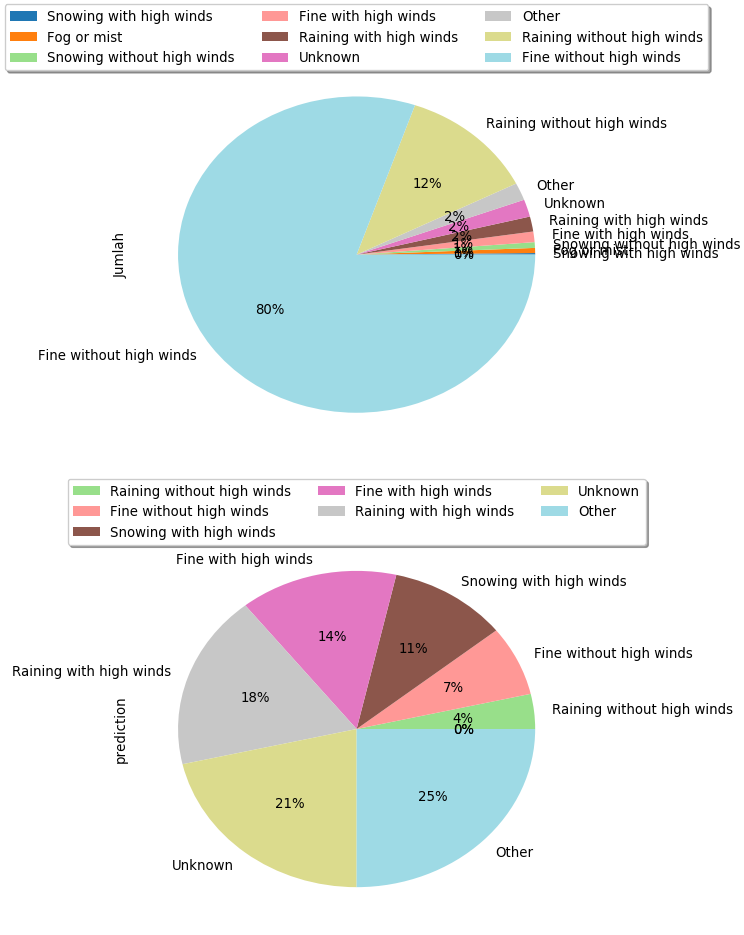

In [17]:
display(predictions)

![image](img/hasil_cluster1.png)

## Clustering 2

## Training

In [18]:
#Pengaruh tipe jalan terhadap speed limit

query2 = spark.sql("SELECT DISTINCT Road_Type, Speed_limit \
                    FROM accidents \
                    GROUP BY Road_Type, Speed_limit")

In [19]:
query2.show()

+------------------+-----------+
|         Road_Type|Speed_limit|
+------------------+-----------+
|  Dual carriageway|         50|
|        Roundabout|         60|
|    One way street|         40|
|Single carriageway|         10|
|    One way street|         60|
|         Slip road|         60|
|        Roundabout|         30|
|Single carriageway|         20|
|         Slip road|         40|
|  Dual carriageway|         40|
|           Unknown|         70|
|Single carriageway|         60|
|         Slip road|         50|
|           Unknown|         30|
|Single carriageway|         50|
|        Roundabout|         70|
|        Roundabout|         20|
|        Roundabout|         40|
|           Unknown|         60|
|         Slip road|         70|
+------------------+-----------+
only showing top 20 rows



In [20]:
# Assembling Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Speed_limit"],
    outputCol='features')

datas = assembler.transform(query2)
datas.show()

+------------------+-----------+--------+
|         Road_Type|Speed_limit|features|
+------------------+-----------+--------+
|  Dual carriageway|         50|  [50.0]|
|        Roundabout|         60|  [60.0]|
|    One way street|         40|  [40.0]|
|Single carriageway|         10|  [10.0]|
|    One way street|         60|  [60.0]|
|         Slip road|         60|  [60.0]|
|        Roundabout|         30|  [30.0]|
|Single carriageway|         20|  [20.0]|
|         Slip road|         40|  [40.0]|
|  Dual carriageway|         40|  [40.0]|
|           Unknown|         70|  [70.0]|
|Single carriageway|         60|  [60.0]|
|         Slip road|         50|  [50.0]|
|           Unknown|         30|  [30.0]|
|Single carriageway|         50|  [50.0]|
|        Roundabout|         70|  [70.0]|
|        Roundabout|         20|  [20.0]|
|        Roundabout|         40|  [40.0]|
|           Unknown|         60|  [60.0]|
|         Slip road|         70|  [70.0]|
+------------------+-----------+--

In [21]:
# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(datas)

In [22]:
# Make a prediction
predictions = model.transform(datas)
predictions.show(30)

+------------------+-----------+--------+----------+
|         Road_Type|Speed_limit|features|prediction|
+------------------+-----------+--------+----------+
|  Dual carriageway|         50|  [50.0]|         6|
|        Roundabout|         60|  [60.0]|         0|
|    One way street|         40|  [40.0]|         1|
|Single carriageway|         10|  [10.0]|         2|
|    One way street|         60|  [60.0]|         0|
|         Slip road|         60|  [60.0]|         0|
|        Roundabout|         30|  [30.0]|         3|
|Single carriageway|         20|  [20.0]|         4|
|         Slip road|         40|  [40.0]|         1|
|  Dual carriageway|         40|  [40.0]|         1|
|           Unknown|         70|  [70.0]|         5|
|Single carriageway|         60|  [60.0]|         0|
|         Slip road|         50|  [50.0]|         6|
|           Unknown|         30|  [30.0]|         3|
|Single carriageway|         50|  [50.0]|         6|
|        Roundabout|         70|  [70.0]|     

In [23]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 1.0


In [26]:
#Get Cluster Center
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[60.]
[40.]
[10.]
[30.]
[20.]
[70.]
[50.]


## Visualization


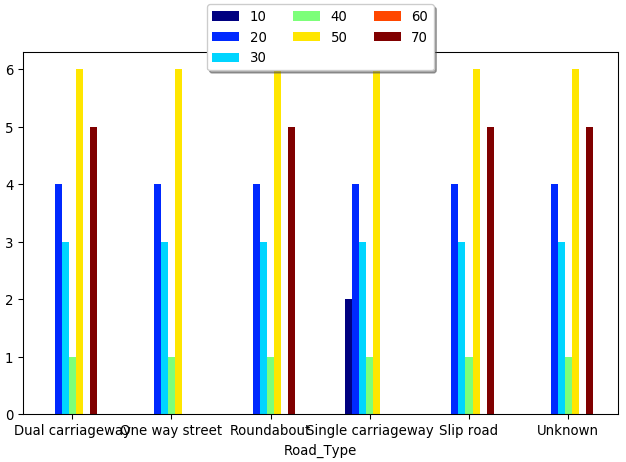

In [27]:
display(predictions)